In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import requests
import json
from bs4 import BeautifulSoup
from PIL import Image
from urllib.request import urlopen
from mplsoccer import Pitch, add_image, FontManager
import LanusStats as ls
sofascore = ls.SofaScore()
from urllib.error import HTTPError

DATOS QUE SE DEBEN EDITAR

In [161]:
url = 'https://www.sofascore.com/football/match/deportes-tolima-atletico-nacional/gxcslxc#id:13222205'
color_loc = 'green'
color_vis = '#FFD700'

In [137]:
partido_sofascore = sofascore.get_match_data(url)

In [138]:
nombre_local, nombre_visit = sofascore.get_team_names(url)
nombre_local
nombre_visit

'Deportes Tolima'

SACAR MATCH MOMENTUM

In [139]:
match_momentum= sofascore.get_match_momentum(url)
match_momentum

,minute,value
0,1.0,2
1,2.0,3
2,3.0,11
3,4.0,12
4,5.0,42
...,...,...
87,87.0,1
88,88.0,-8
89,89.0,-10
90,90.0,-54


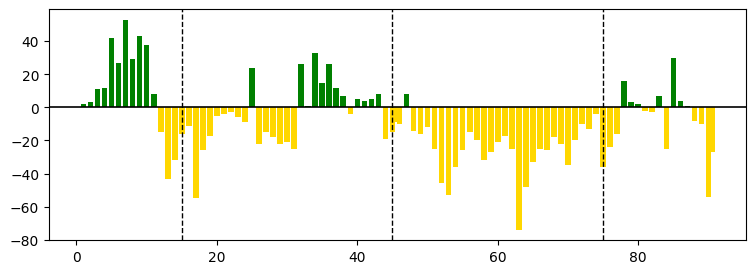

In [162]:
fig, ax = plt.subplots(figsize=(9,3))
match_momentum_local = match_momentum[match_momentum['value'] > 0]
match_momentum_visit = match_momentum[match_momentum['value'] < 0]

plt.bar(match_momentum_local.minute, match_momentum_local.value, color=color_loc)
plt.bar(match_momentum_visit.minute, match_momentum_visit.value, color=color_vis)

# Líneas verticales punteadas para momentos clave (opcional, por ejemplo, minuto 45, etc.)
ax.axvline(x=45, color='black', linestyle='--', linewidth=1)
ax.axvline(x=15, color='black', linestyle='--', linewidth=1)
ax.axvline(x=75, color='black', linestyle='--', linewidth=1)

# Añadir la línea horizontal en el valor 0
ax.axhline(0, color='black', linewidth=1.2)


SACAR JUFADORES DESTACADOS

In [141]:
df_local = sofascore.get_players_match_stats(url)[0]
df_visit = sofascore.get_players_match_stats(url)[1]

In [142]:
df_local['percentage_pass'] = (df_local['accuratePass'] / df_local['totalPass']) * 100
df_visit['percentage_pass'] = (df_visit['accuratePass'] / df_visit['totalPass']) * 100

In [165]:
df_filtrado = df_visit[['shortName','touches','totalPass','keyPass','percentage_pass']]

In [144]:
lista_mayores = ['duelWon', 'touches', 'keyPass','percentage_pass']
nombre_mayores_local = []
valor_mayores_local = []
nombre_mayores_visit = []
valor_mayores_visit = []

for i in range(len(lista_mayores)):
    nombre = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_local.append(nombre)
    valor_mayores_local.append(valor)

for i in range(len(lista_mayores)):
    nombre = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_visit.append(nombre)
    valor_mayores_visit.append(valor)

nombre_mayores_local, valor_mayores_local

(['Jorman Campuzano', 'Jorman Campuzano', 'Marino Hinestroza', 'Juan Zapata'],
 [7.0, 46.0, 5.0, 90.0])

In [145]:
nombre_mayores_visit, valor_mayores_visit

(['Yhorman Hurtado', 'Yeison Guzmán', 'Yeison Guzmán', 'William Cuesta'],
 [4.0, 87.0, 2.0, 100.0])

In [146]:
def sacar_spines(ax):
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

DATOS JUGADOR DESTACADO

In [147]:
jugador_destacado_local = df_local[['name','rating']].sort_values(by='rating', ascending=False).iloc[0]['name']
jugador_destacado_visit = df_visit[['name','rating']].sort_values(by='rating', ascending=False).iloc[0]['name']
id_jug_local = df_local[df_local['name'] == jugador_destacado_local].id.values[0]
id_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit].id.values[0] 
df_jug_local = df_local[df_local['name'] == jugador_destacado_local]
df_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit]

In [148]:
lista_estadisticas = ['totalPass', 'accuratePass', 'goalAssist', 'duelWon', 'duelLost', 'keyPass', 'touches', 'totalTackle', 'interceptionWon', 'totalClearance']
valores_jug_local = df_jug_local[lista_estadisticas].values
valores_jug_visit = df_jug_visit[lista_estadisticas].values
valores_jug_local


array([[18., 13.,  1.,  1.,  1.,  2., 33.,  1.,  2.,  3.]])

In [149]:
valores_jug_visit

array([[73., 68.,  0.,  4., nan, nan, 81.,  1.,  1., nan]])

MAPAS DE CALOR JUGADORES DESTACADOS

In [150]:
mapa_calor_jug_vis = sofascore.get_player_heatmap(url, player=jugador_destacado_visit)

In [151]:
mapa_calor_jug_loc = sofascore.get_player_heatmap(url, player=jugador_destacado_local)

SACAR ESCUDOS

In [152]:
idlocal = partido_sofascore['event']['homeTeam']['id']
idvisit = partido_sofascore['event']['awayTeam']['id']

In [153]:
imagen1 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idlocal}/image'))
imagen2 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idvisit}/image'))

SACAR INFO DEL PARTIDO

In [154]:
goleslocal = partido_sofascore['event']['homeScore']['normaltime']
golesvisit = partido_sofascore['event']['awayScore']['normaltime']

torneo = partido_sofascore['event']['season']['name']
fecha = partido_sofascore['event']['roundInfo']['round']

MAPAS DE TIROS

In [155]:
shotmap = sofascore.get_match_shotmap(url)
tiros = shotmap[['isHome','shotType', 'name','id','x','y']]

In [156]:
tiros.isHome = tiros.isHome.apply(lambda x: 'Local' if x == True else 'Visitante')
tiros.shotType = tiros.shotType.apply(lambda x: 'Gol' if x == 'goal' else 'Tiro')
tiros

,isHome,shotType,name,id,id,x,y
0,Visitante,Tiro,Luis Miranda,4187684,891115,30.1,74.4
1,Visitante,Tiro,Brayan Gil,4187683,1065361,14.8,48.1
2,Local,Tiro,Juan Zapata,4187682,983231,10.3,35.6
3,Local,Tiro,Kevin Viveros,4187681,925124,14.5,50.9
4,Local,Tiro,Kevin Viveros,4187679,925124,13.0,47.9
5,Local,Tiro,Juan Zapata,4187680,983231,10.5,68.1
6,Local,Tiro,Kevin Viveros,4187678,925124,27.0,35.2
7,Visitante,Tiro,Yeison Guzmán,4187677,870359,11.5,50.0
8,Visitante,Tiro,Brayan Gil,4187676,1065361,12.8,56.3
9,Visitante,Tiro,Juan Pablo Nieto,4187675,338861,23.7,69.1


In [ ]:
tiros_local = tiros[tiros['isHome'] == 'Local']
tiros_visit = tiros[tiros['isHome'] == 'Visitante']

,isHome,shotType,name,id,id,x,y
2,Local,Tiro,Juan Zapata,4187682,983231,10.3,35.6
3,Local,Tiro,Kevin Viveros,4187681,925124,14.5,50.9
4,Local,Tiro,Kevin Viveros,4187679,925124,13.0,47.9
5,Local,Tiro,Juan Zapata,4187680,983231,10.5,68.1
6,Local,Tiro,Kevin Viveros,4187678,925124,27.0,35.2
10,Local,Tiro,Marino Hinestroza,4187430,972587,10.8,57.4
11,Local,Tiro,Edwin Cardona,4187429,153793,26.0,37.6
12,Local,Gol,Andrés Román,4187428,870013,10.7,64.4
13,Local,Tiro,Edwin Cardona,4187410,153793,21.6,68.7
14,Local,Tiro,Alfredo Morelos,4187409,831085,6.7,67.2


CREACIÓN INFORME FINAL

"\nax10 = fig.add_subplot(gs[2:,:1])\nax10.set_title('Mayor numero local')\nax10.text(0,.8, f'Más duelos ganados: {nombre_mayores_local[0]} - {valor_mayores_local[0]}', ha='left', va='center')\nax10.text(0,.55, f'Más toques: {nombre_mayores_local[1]} - {int(valor_mayores_local[1])}', ha='left', va='center')\nax10.text(0,.3, f'Más pases claves: {nombre_mayores_local[2]} - {int(valor_mayores_local[2])}', ha='left', va='center')\nax10.text(0,.05, f'Más Goles Esperados: {nombre_mayores_local[3]} - {valor_mayores_local[3]}', ha='left', va='center')\nsacar_spines(ax10)\n"

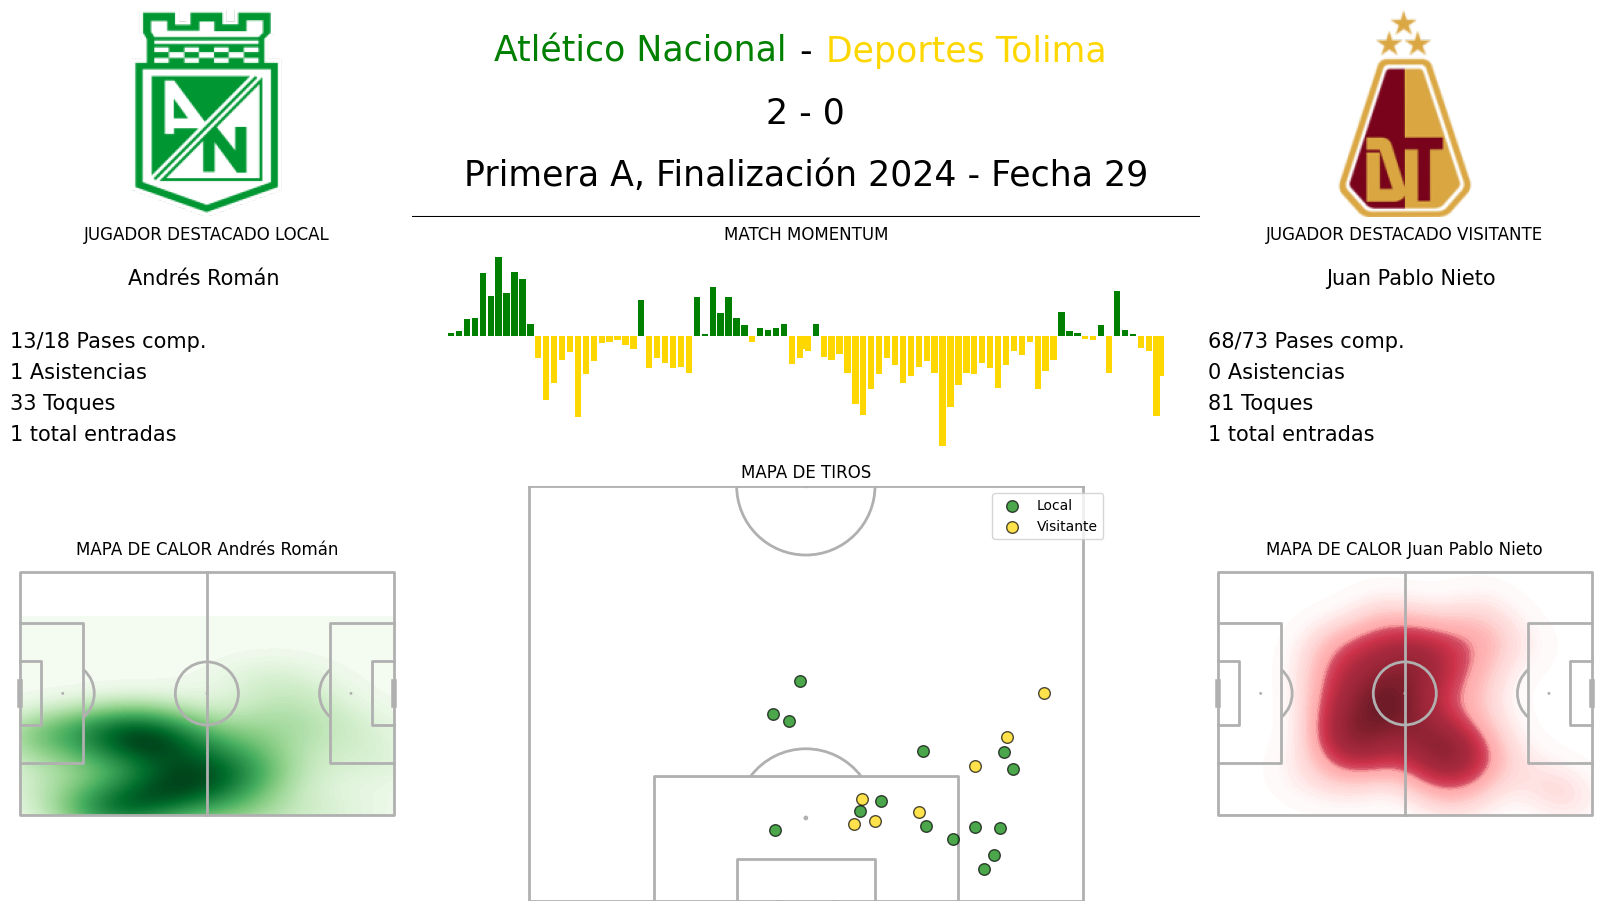

In [168]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=4,ncols=4)
fig.set_facecolor('white')

#Escudo local
ax1 = fig.add_subplot(gs[0,0:1])
ax1.imshow(imagen1)
sacar_spines(ax1)

#Escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])
ax2.imshow(imagen2)
sacar_spines(ax2)

#datos del partido
ax3 = fig.add_subplot(gs[0,1:3])
ax3.text(.475,.8,f'{nombre_local}', ha='right', va='center', size=25, color=color_loc)
ax3.text(.525,.8,f'{nombre_visit}', ha='left', va='center', size=25, color=color_vis)
ax3.text(.5,.8,'-', ha='center', va='center', size=25)
ax3.text(.5,.5,f'{goleslocal} - {golesvisit}', ha='center', va='center', size=25)
ax3.text(.5,.2,f'{torneo} - Fecha {fecha}', ha='center', va='center', size=25)
ax3.axhline(0, color='black')
sacar_spines(ax3)


lista_estadisticas = ['totalPass', 'accuratePass', 'goalAssist', 'duelWon', 'duelLost', 'keyPass', 'touches', 'totalTackle', 'interceptionWon', 'totalClearance']
#jugador destacado local
ax10 = fig.add_subplot(gs[1:2,:1])
ax10.set_title('JUGADOR DESTACADO LOCAL')
valores_jug_local = df_jug_local[lista_estadisticas].values
ax10.text(.3,.85,f'{jugador_destacado_local}', ha='left', va='center', size=15)
ax10.text(0,.55,f'{int(valores_jug_local[0][1])}/{int(valores_jug_local[0][0])} Pases comp.', ha='left', va='center', size=15)
ax10.text(0,.4,f'{int(valores_jug_local[0][2])} Asistencias', ha='left', va='center', size=15)
ax10.text(0,.25,f'{int(valores_jug_local[0][6])} Toques', ha='left', va='center', size=15)
ax10.text(0,.1,f'{int(valores_jug_local[0][7])} total entradas', ha='left', va='center', size=15)
#ax10.text(0,.4,f'{int(valores_jug_local[0][7])+int(valores_jug_local[0][8])+int(valores_jug_local[0][9])} Acc. defensivas', ha='left', va='center', size=20)
#ax10.axhline(0, color='black')
sacar_spines(ax10)

#jugador destacado visitante
ax9 = fig.add_subplot(gs[1:2,3:])
ax9.set_title('JUGADOR DESTACADO VISITANTE')
valores_jug_visit = df_jug_visit[lista_estadisticas].values
ax9.text(.3,.85,f'{jugador_destacado_visit}', ha='left', va='center', size=15)
ax9.text(0,.55,f'{int(valores_jug_visit[0][1])}/{int(valores_jug_visit[0][0])} Pases comp.', ha='left', va='center', size=15)
ax9.text(0,.4,f'{int(valores_jug_visit[0][2])} Asistencias', ha='left', va='center', size=15)
ax9.text(0,.25,f'{int(valores_jug_visit[0][6])} Toques', ha='left', va='center', size=15)
ax9.text(0,.1,f'{int(valores_jug_visit[0][7])} total entradas', ha='left', va='center', size=15)
#ax9.text(0,.4,f'{int(valores_jug_visit[0][9])} Acc. defensivas', ha='left', va='center', size=20)
#ax9.axhline(0, color='black')
sacar_spines(ax9)

# Mapa de calor local
ax5 = fig.add_subplot(gs[2:, :1])
ax5.set_title(f'MAPA DE CALOR {jugador_destacado_local}')
# Dibujar el campo en el subplot correcto (ax5)
pitch_local = Pitch(pitch_type='opta')
pitch_local.draw(ax=ax5)  # Dibuja el campo en ax5
# Graficar el mapa de calor en el subplot correcto (ax5)
pitch_local.kdeplot(
    mapa_calor_jug_loc.x, 
    mapa_calor_jug_loc.y, 
    ax=ax5,
    levels=100,
    shade=True,
    zorder=-1,
    shade_lowest=True,
    cmap='Greens'  # Ajustar colormap si es necesario
)
sacar_spines(ax5)


# Mapa de calor visitante
ax6 = fig.add_subplot(gs[2:,3:])
ax6.set_title(f'MAPA DE CALOR {jugador_destacado_visit}')
# Dibujar el campo en el subplot correcto (ax5)
pitch_visit = Pitch(pitch_type='opta')
pitch_visit.draw(ax=ax6)  # Dibuja el campo en ax5
# Graficar el mapa de calor en el subplot correcto (ax5)
pitch_visit.kdeplot(
    mapa_calor_jug_vis.x, 
    mapa_calor_jug_vis.y, 
    ax=ax6,
    levels=100,
    shade=True,
    zorder=-1,
    shade_lowest=True,
    cmap='granate_blanco'  # Ajustar colormap si es necesario
)
sacar_spines(ax6)

#MATCH MOMENTUM
ax7 = fig.add_subplot(gs[1:2,1:3])
ax7.set_title('MATCH MOMENTUM')
match_momentum_local = match_momentum[match_momentum['value'] > 0]
match_momentum_visit = match_momentum[match_momentum['value'] < 0]
plt.bar(match_momentum_local.minute, match_momentum_local.value, color=color_loc)
plt.bar(match_momentum_visit.minute, match_momentum_visit.value, color=color_vis)
# Líneas verticales punteadas para momentos clave (opcional, por ejemplo, minuto 45, etc.)
ax.axvline(x=45, color='black', linestyle='--', linewidth=1)
ax.axvline(x=15, color='black', linestyle='--', linewidth=1)
ax.axvline(x=75, color='black', linestyle='--', linewidth=1)
# Añadir la línea horizontal en el valor 0
ax.axhline(0, color='black', linewidth=1.2)
sacar_spines(ax7)


#MAPA DE TIROS
ax8 = fig.add_subplot(gs[2:,1:3])
ax8.set_title('MAPA DE TIROS')
#fig, ax8 = plt.subplots(figsize=(8,4))
pitch = VerticalPitch(
    pitch_type='statsbomb',
    goal_type='box'
)
pitch.draw(ax=ax8)
plt.ylim(0, 60)
pitch.scatter(tiros_local.x, tiros_local.y, ax=ax8, color=color_loc, s=70, alpha=0.7, ec='black' ,label='Local')
pitch.scatter(tiros_visit.x, tiros_visit.y, ax=ax8, color=color_vis, s=70, alpha=0.7, ec='black', label='Visitante')
plt.legend()
sacar_spines(ax8)

"""
ax10 = fig.add_subplot(gs[2:,:1])
ax10.set_title('Mayor numero local')
ax10.text(0,.8, f'Más duelos ganados: {nombre_mayores_local[0]} - {valor_mayores_local[0]}', ha='left', va='center')
ax10.text(0,.55, f'Más toques: {nombre_mayores_local[1]} - {int(valor_mayores_local[1])}', ha='left', va='center')
ax10.text(0,.3, f'Más pases claves: {nombre_mayores_local[2]} - {int(valor_mayores_local[2])}', ha='left', va='center')
ax10.text(0,.05, f'Más Goles Esperados: {nombre_mayores_local[3]} - {valor_mayores_local[3]}', ha='left', va='center')
sacar_spines(ax10)
"""



In [160]:
plt.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight